## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import Normalizer

## Data Cleaning

In [2]:
household_data = pd.read_excel('household.xlsx', sheet_name='Sheet1')

In [3]:
dict(household_data.isnull().sum())

{'HH1': 0,
 'HH2': 0,
 'HH6': 0,
 'HH7': 0,
 'HH48': 316,
 'HH49': 316,
 'HH50': 316,
 'HH51': 316,
 'HH52': 316,
 'HC1A': 316,
 'HC3': 316,
 'HC4': 316,
 'HC5': 316,
 'HC6': 316,
 'HC7A': 316,
 'HC7F': 316,
 'HC7G': 316,
 'HC7H': 316,
 'HC7I': 316,
 'HC7J': 316,
 'HC7K': 316,
 'HC8': 316,
 'HC9B': 3183,
 'HC9G': 3183,
 'HC9H': 3183,
 'HC9K': 3183,
 'HC9L': 3183,
 'HC9M': 3183,
 'HC9N': 3183,
 'HC9P': 3183,
 'HC10B': 316,
 'HC10C': 316,
 'HC10D': 316,
 'HC10E': 316,
 'HC10F': 316,
 'HC10G': 316,
 'HC10H': 316,
 'HC11': 316,
 'HC12': 316,
 'HC13': 316,
 'HC14': 316,
 'HC17': 316,
 'HC19': 316,
 'EU1': 316,
 'EU2': 8611,
 'EU3': 8611,
 'EU4': 2830,
 'EU5': 559,
 'EU6': 316,
 'EU7': 12968,
 'EU8': 12365,
 'EU9': 316,
 'TN1': 316,
 'TN2': 3245,
 'IR1': 316,
 'WS1': 316,
 'WS3': 2610,
 'WS4': 3512,
 'WS5': 4068,
 'WS6': 4068,
 'WS7': 316,
 'WS8A': 11850,
 'WS9': 316,
 'WS10AA': 316,
 'WS11': 316,
 'WS12': 4017,
 'WS13': 10249,
 'WS14': 3593,
 'WS15': 3593,
 'WS16': 6411,
 'WS17': 10292,
 'H

In [4]:
household_data = household_data[~household_data['HH48'].isnull()]

In [5]:
def drop_cols(df, null_percentage):
    '''The function drops the columns which have null percentage greater than given null percentage by the user,
    INPUTS:
        df = The dataframe from which columns need to be dropped
        null_percentage = A numerical figure provided by user which acts as a threshold for null_percenatge 
    OUTPUT
        The function returns True if all columns are dropped successfully else it returns False
    '''
    try:
        total_rows = len(df)
        for column in df.columns:
            if (df[column].isnull().sum() / total_rows)*100> null_percentage:
                df.drop(columns=column, inplace=True)
        return True
    except Exception as e:
        logging.error("Exception occurred at drop_cols", exc_info=True)
        return False
if drop_cols(household_data, 50):
    print('Columns Dropped Successfully')
else:
    print('Unable to drop columns check logs for more info')

Columns Dropped Successfully


In [6]:
dict(household_data.isnull().sum())

{'HH1': 0,
 'HH2': 0,
 'HH6': 0,
 'HH7': 0,
 'HH48': 0,
 'HH49': 0,
 'HH50': 0,
 'HH51': 0,
 'HH52': 0,
 'HC1A': 0,
 'HC3': 0,
 'HC4': 0,
 'HC5': 0,
 'HC6': 0,
 'HC7A': 0,
 'HC7F': 0,
 'HC7G': 0,
 'HC7H': 0,
 'HC7I': 0,
 'HC7J': 0,
 'HC7K': 0,
 'HC8': 0,
 'HC9B': 2867,
 'HC9G': 2867,
 'HC9H': 2867,
 'HC9K': 2867,
 'HC9L': 2867,
 'HC9M': 2867,
 'HC9N': 2867,
 'HC9P': 2867,
 'HC10B': 0,
 'HC10C': 0,
 'HC10D': 0,
 'HC10E': 0,
 'HC10F': 0,
 'HC10G': 0,
 'HC10H': 0,
 'HC11': 0,
 'HC12': 0,
 'HC13': 0,
 'HC14': 0,
 'HC17': 0,
 'HC19': 0,
 'EU1': 0,
 'EU4': 2514,
 'EU5': 243,
 'EU6': 0,
 'EU9': 0,
 'TN1': 0,
 'TN2': 2929,
 'IR1': 0,
 'WS1': 0,
 'WS3': 2294,
 'WS4': 3196,
 'WS5': 3752,
 'WS6': 3752,
 'WS7': 0,
 'WS9': 0,
 'WS10AA': 0,
 'WS11': 0,
 'WS12': 3701,
 'WS14': 3277,
 'WS15': 3277,
 'WS16': 6095,
 'HW1': 0,
 'HW2': 3554,
 'HW3': 3554,
 'HW5': 5548,
 'HW8A': 1708,
 'HW8C': 2260,
 'HW9A': 1171,
 'SA1': 0,
 'wscore': 0,
 'windex5': 0,
 'windex10': 0,
 'wscorer': 6153,
 'windex5r': 6153,


In [7]:
'''Households which dont have access to Electricity wont have access to electrical appliacnces as well,
   thus filling up the values with NO'''

col_list = ['HC9B',
 'HC9G',
 'HC9H',
 'HC9K',
 'HC9L',
 'HC9M',
 'HC9N',
 'HC9P']
household_data.loc[household_data['HC8']=='NO', col_list]='NO'

In [8]:
for col in col_list:
    print(pd.DataFrame(household_data[col].value_counts()))

     HC9B
NO   8886
YES  4000
              HC9G
NO           12597
YES            288
NO RESPONSE      1
              HC9H
NO           12576
YES            308
NO RESPONSE      2
      HC9K
NO   12757
YES    129
              HC9L
NO           12692
YES            193
NO RESPONSE      1
     HC9M
NO   7148
YES  5738
              HC9N
NO           12839
YES             45
NO RESPONSE      2
      HC9P
NO   12405
YES    481


In [9]:
'''Filling Blanks in Source of Fuel for cooking'''
household_data.loc[household_data['EU1']=='NO FOOD COOKED IN HOUSEHOLD', ['EU4', 'EU5']]='NONE'
household_data.loc[household_data['EU4'].isnull(), 'EU4'] = 'OTHER'

In [10]:
'''For households with no mosqiuto nets, filling up data with 0'''
household_data['TN2'].fillna(0, inplace=True)

Filling up blanks for water sources

In [11]:
household_data.loc[(household_data['WS1']=='PIPED WATER: PIPED TO YARD / PLOT')&(household_data['WS3'].isnull()), 'WS3'] ='IN OWN YARD / PLOT'
household_data.loc[(household_data['WS1']=='PIPED WATER : PIPED INTO DWELLING')&(household_data['WS3'].isnull()), 'WS3'] ='IN OWN DWELLING'
household_data['WS3'].fillna('ELSEWHERE', inplace=True)

In [12]:
household_data.loc[household_data['WS4']=='MEMBERS DO NOT COLLECT','WS4'] = 0

In [13]:
household_data[household_data['WS4'].isnull()]['WS1'].value_counts()

PACKAGED WATER: SACHET WATER           1594
PIPED WATER: PIPED TO YARD / PLOT       574
PIPED WATER : PIPED INTO DWELLING       336
TUBE WELL / BOREHOLE                    173
PIPED WATER: PUBLIC TAP / STANDPIPE     126
RAINWATER                               108
DUG WELL: PROTECTED WELL                100
PACKAGED WATER: BOTTLED WATER            77
DUG WELL: UNPROTECTED WELL               75
PIPED WATER: PIPED TO NEIGHBOUR          26
OTHER                                     4
SPRING: UNPROTECTED SPRING                2
SPRING: PROTECTED SPRING                  1
Name: WS1, dtype: int64

In [14]:
household_data.drop(columns='WS4', inplace=True)#Dropping column because of high skewness and not much relevance to target

In [15]:
household_data.drop(columns=['WS5', 'WS6'], inplace=True)

In [16]:
household_data['WS12'].fillna('None', inplace=True)

In [17]:
household_data['WS14'].fillna('ELSEWHERE', inplace=True)

In [18]:
household_data['WS15'].fillna('YES', inplace=True)

In [19]:
household_data['WS16'] = np.where((household_data['WS16'].isnull())&(household_data['WS15']=='NO'),'NOT SHARED', household_data['WS16'])


In [20]:
household_data['WS16'].fillna('SHARED WITH GENERAL PUBLIC', inplace=True)

In [21]:
household_data['HW2'] = np.where((household_data['HW2'].isnull())&(household_data['HW1']=='NOT OBSERVED: NO HANDWASHING PLACE IN DWELLING / YARD / PLOT'),'WATER IS NOT AVAILABLE', household_data['HW2'])
household_data['HW2'].fillna('NO RESPONSE', inplace=True)

In [22]:
household_data['HW3'] = np.where((household_data['HW3'].isnull())&(household_data['HW1']=='NOT OBSERVED: NO HANDWASHING PLACE IN DWELLING / YARD / PLOT'),'NO, NOT PRESENT', household_data['HW3'])
household_data['HW3'].fillna('NO RESPONSE', inplace=True)

In [23]:
household_data['HW5'].fillna('NO', inplace=True)

In [24]:
household_data['HW8A'].fillna('NO RESPONSE', inplace=True)
household_data['HW8C'].fillna('NO RESPONSE', inplace=True)
household_data['HW9A'].fillna('NO RESPONSE', inplace=True)


In [25]:
dict(household_data.isnull().sum())

{'HH1': 0,
 'HH2': 0,
 'HH6': 0,
 'HH7': 0,
 'HH48': 0,
 'HH49': 0,
 'HH50': 0,
 'HH51': 0,
 'HH52': 0,
 'HC1A': 0,
 'HC3': 0,
 'HC4': 0,
 'HC5': 0,
 'HC6': 0,
 'HC7A': 0,
 'HC7F': 0,
 'HC7G': 0,
 'HC7H': 0,
 'HC7I': 0,
 'HC7J': 0,
 'HC7K': 0,
 'HC8': 0,
 'HC9B': 0,
 'HC9G': 0,
 'HC9H': 0,
 'HC9K': 0,
 'HC9L': 0,
 'HC9M': 0,
 'HC9N': 0,
 'HC9P': 0,
 'HC10B': 0,
 'HC10C': 0,
 'HC10D': 0,
 'HC10E': 0,
 'HC10F': 0,
 'HC10G': 0,
 'HC10H': 0,
 'HC11': 0,
 'HC12': 0,
 'HC13': 0,
 'HC14': 0,
 'HC17': 0,
 'HC19': 0,
 'EU1': 0,
 'EU4': 0,
 'EU5': 0,
 'EU6': 0,
 'EU9': 0,
 'TN1': 0,
 'TN2': 0,
 'IR1': 0,
 'WS1': 0,
 'WS3': 0,
 'WS7': 0,
 'WS9': 0,
 'WS10AA': 0,
 'WS11': 0,
 'WS12': 0,
 'WS14': 0,
 'WS15': 0,
 'WS16': 0,
 'HW1': 0,
 'HW2': 0,
 'HW3': 0,
 'HW5': 0,
 'HW8A': 0,
 'HW8C': 0,
 'HW9A': 0,
 'SA1': 0,
 'wscore': 0,
 'windex5': 0,
 'windex10': 0,
 'wscorer': 6153,
 'windex5r': 6153,
 'windex10r': 6153}

## Merging

In [26]:
birth_data = pd.read_spss(r'D:\Chetan-PC\DataSets\DMML\Ghana MICS6 SPSS Datasets\bh.sav', usecols = ['HH1', 'HH2','BH2', 'BH3', 'BH4Y','BH5', 'BH6','BH9U', 'BH9N', 'BH10', 'brthord', 'magebrt', 'birthint', 'welevel', 'disability', 'BH4Y_first','BH6_first', 'BH3_last', 'BH4Y_last', 'BH6_last','wmweight'])

In [27]:
birth_data.isnull().sum()

HH1               0
HH2               0
BH2               0
BH3               0
BH4Y              0
BH5               0
BH6            2903
BH9U          31692
BH9N          31692
BH10              0
brthord           0
magebrt           0
birthint          0
welevel           0
disability      104
BH4Y_first        0
BH6_first       103
BH3_last          0
BH4Y_last         0
BH6_last        103
wmweight          0
dtype: int64

In [28]:
birth_data['disability'].value_counts()

Has no functional difficulty    30416
Has functional difficulty        4075
Name: disability, dtype: int64

In [29]:
birth_data['BH9N'] = birth_data['BH9N'].astype(str)
temp_df = birth_data[birth_data['BH6'].isnull()]

In [30]:
temp_df['BH6'] = np.where(temp_df['BH9U']=='YEARS', temp_df['BH9N'].astype(float), temp_df['BH6'])
temp_df['BH6'] = np.where(temp_df['BH9U']=='MONTHS', temp_df['BH9N'].astype(float)/12, temp_df['BH6'])
temp_df['BH6'] = np.where(temp_df['BH9U']=='DAYS', temp_df['BH9N'].astype(float)/365, temp_df['BH6'])

<ipython-input-30-c7bc6b4a7b7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['BH6'] = np.where(temp_df['BH9U']=='YEARS', temp_df['BH9N'].astype(float), temp_df['BH6'])
<ipython-input-30-c7bc6b4a7b7d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['BH6'] = np.where(temp_df['BH9U']=='MONTHS', temp_df['BH9N'].astype(float)/12, temp_df['BH6'])
<ipython-input-30-c7bc6b4a7b7d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [31]:
birth_data['BH6'] = birth_data['BH6'].astype('str').astype('float')

In [32]:
birth_data[birth_data['BH6'].isnull()] = temp_df 

In [33]:
birth_data.drop(columns=['BH4Y_first','BH6_first','BH3_last','BH4Y_last','BH6_last'], inplace=True)
birth_data = birth_data[birth_data['disability'].notnull()]

In [34]:
birth_data.drop(columns=['BH9U','BH9N'], inplace=True)

In [35]:
birth_data.isnull().sum()

HH1           0
HH2           0
BH2           0
BH3           0
BH4Y          0
BH5           0
BH6           0
BH10          0
brthord       0
magebrt       0
birthint      0
welevel       0
disability    0
wmweight      0
dtype: int64

In [36]:
birth_data_less_than_five = birth_data[birth_data['BH6']<=5]

In [37]:
birth_data_less_than_five.shape

(12355, 14)

In [38]:
final_merged_data = household_data.merge(birth_data_less_than_five, on=['HH1', 'HH2'], how='inner')

In [39]:
# final_merged_data = pd.read_csv('dataset2.csv')

In [40]:
for column in final_merged_data.columns:
    if final_merged_data[column].dtypes=='O':
        final_merged_data[column] = final_merged_data[column].astype('category')

In [41]:
dict(final_merged_data.dtypes)

{'HH1': dtype('int64'),
 'HH2': dtype('int64'),
 'HH6': CategoricalDtype(categories=['RURAL', 'URBAN'], ordered=False),
 'HH7': CategoricalDtype(categories=['ASHANTI', 'BRONG AHAFO', 'CENTRAL', 'EASTERN',
                   'GREATER ACCRA', 'NORTHERN', 'UPPER EAST', 'UPPER WEST',
                   'VOLTA', 'WESTERN'],
                  ordered=False),
 'HH48': dtype('float64'),
 'HH49': dtype('float64'),
 'HH50': dtype('float64'),
 'HH51': dtype('float64'),
 'HH52': dtype('float64'),
 'HC1A': CategoricalDtype(categories=['ANGLICAN', 'CATHOLIC', 'ISLAM', 'METHODIST', 'NO RELIGION',
                   'NO RESPONSE', 'OTHER CHRISTIAN', 'OTHER RELIGION (SPECIFY',
                   'PENTECOSTAL/CHARISMATIC', 'PRESBYTERIAN',
                   'TRADITIONAL/SPIRITUAL'],
                  ordered=False),
 'HC3': dtype('float64'),
 'HC4': CategoricalDtype(categories=['CARPET', 'CEMENT', 'CERAMIC TILES', 'DUNG', 'EARTH / SAND',
                   'OTHER', 'PALM / BAMBOO', 'PARQUET OR POLISHED 

In [42]:
final_df = final_merged_data.drop(columns=['wscorer','windex5', 'windex10r'])

## Feature Engineering

In [43]:
# map_dict = {'URBAN':1, 'RURAL':2}
# final_df['HH6'] = final_df['HH6'].map(map_dict)

In [44]:
# map_dict = {'WESTERN': 1,
# 'CENTRAL':2,
# 'GREATER ACCRA':3,
# 'VOLTA':4,
# 'EASTERN':5,
# 'ASHANTI':6,
# 'BRONG AHAFO':7,
# 'NORTHERN':8,
# 'UPPER EAST':9,
# 'UPPER WEST':10}
# final_df['HH7'] = final_df['HH7'].map(map_dict)

In [45]:
cols_to_transform=[]
for column in final_df.columns:
    if final_df[column].dtype !=float:
        cols_to_transform.append(column)

In [46]:
dict(final_df[cols_to_transform].dtypes)

{'HH1': dtype('int64'),
 'HH2': dtype('int64'),
 'HH6': CategoricalDtype(categories=['RURAL', 'URBAN'], ordered=False),
 'HH7': CategoricalDtype(categories=['ASHANTI', 'BRONG AHAFO', 'CENTRAL', 'EASTERN',
                   'GREATER ACCRA', 'NORTHERN', 'UPPER EAST', 'UPPER WEST',
                   'VOLTA', 'WESTERN'],
                  ordered=False),
 'HC1A': CategoricalDtype(categories=['ANGLICAN', 'CATHOLIC', 'ISLAM', 'METHODIST', 'NO RELIGION',
                   'NO RESPONSE', 'OTHER CHRISTIAN', 'OTHER RELIGION (SPECIFY',
                   'PENTECOSTAL/CHARISMATIC', 'PRESBYTERIAN',
                   'TRADITIONAL/SPIRITUAL'],
                  ordered=False),
 'HC4': CategoricalDtype(categories=['CARPET', 'CEMENT', 'CERAMIC TILES', 'DUNG', 'EARTH / SAND',
                   'OTHER', 'PALM / BAMBOO', 'PARQUET OR POLISHED WOOD',
                   'STONE', 'TERRAZZO', 'VINYL OR ASPHALT STRIPS',
                   'WOOD PLANKS'],
                  ordered=False),
 'HC5': Categorica

In [47]:
final_df.columns

Index(['HH1', 'HH2', 'HH6', 'HH7', 'HH48', 'HH49', 'HH50', 'HH51', 'HH52',
       'HC1A', 'HC3', 'HC4', 'HC5', 'HC6', 'HC7A', 'HC7F', 'HC7G', 'HC7H',
       'HC7I', 'HC7J', 'HC7K', 'HC8', 'HC9B', 'HC9G', 'HC9H', 'HC9K', 'HC9L',
       'HC9M', 'HC9N', 'HC9P', 'HC10B', 'HC10C', 'HC10D', 'HC10E', 'HC10F',
       'HC10G', 'HC10H', 'HC11', 'HC12', 'HC13', 'HC14', 'HC17', 'HC19', 'EU1',
       'EU4', 'EU5', 'EU6', 'EU9', 'TN1', 'TN2', 'IR1', 'WS1', 'WS3', 'WS7',
       'WS9', 'WS10AA', 'WS11', 'WS12', 'WS14', 'WS15', 'WS16', 'HW1', 'HW2',
       'HW3', 'HW5', 'HW8A', 'HW8C', 'HW9A', 'SA1', 'wscore', 'windex10',
       'windex5r', 'BH2', 'BH3', 'BH4Y', 'BH5', 'BH6', 'BH10', 'brthord',
       'magebrt', 'birthint', 'welevel', 'disability', 'wmweight'],
      dtype='object')

In [48]:
feature_df = final_df[cols_to_transform].astype('str').astype('category').apply(LabelEncoder().fit_transform)

In [49]:
target = feature_df['BH5']#.drop(columns = 'BH5')

In [50]:
feature_df = feature_df.drop(columns = 'BH5')

### Oversampling

In [51]:
adasyn = ADASYN()

X_adasyn, y_adasyn = adasyn.fit_resample(feature_df,target)



In [52]:
print('The number of lines before oversampling : {}'.format(feature_df[feature_df.columns[1:]].shape[0]))
print('The number of lines after oversampling : {}'.format(X_adasyn.shape[0]))

The number of lines before oversampling : 12355
The number of lines after oversampling : 19324


In [53]:
# def normalize(column):
#     upper = column.max()
#     lower = column.min()
#     y = (column - lower)/(upper-lower)
#     return y
# X_adasyn['BH4Y'] = normalize(X_adasyn['BH4Y']**3)

In [54]:
# X_adasyn['BH4Y'] = X_adasyn['BH4Y'].astype('category')

In [55]:
# X_adasyn['WS11'] = normalize(X_adasyn['WS11']**2)
# X_adasyn['WS11'] = X_adasyn['WS11'].astype('category')

<ipython-input-56-4d442a976c21>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


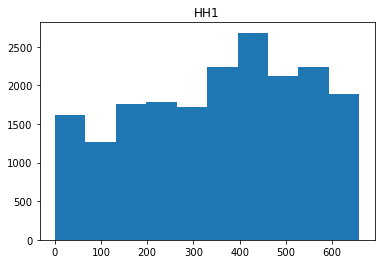

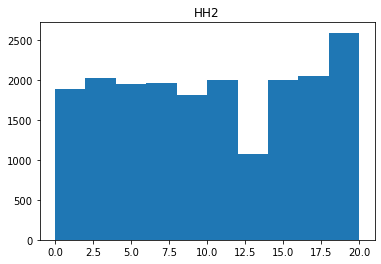

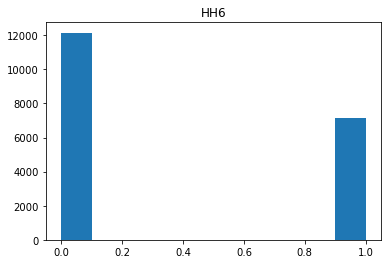

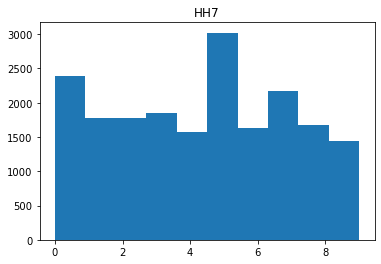

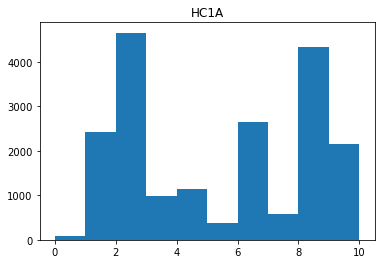

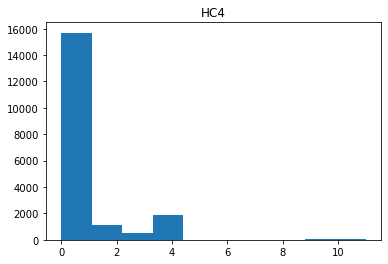

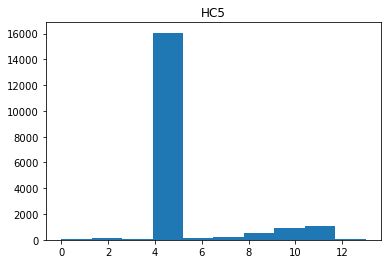

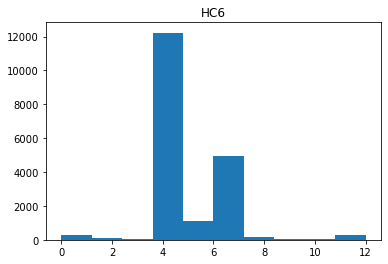

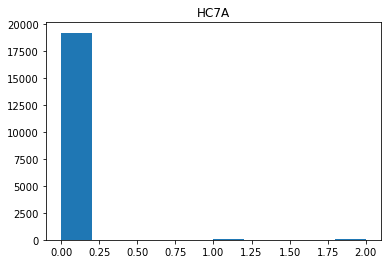

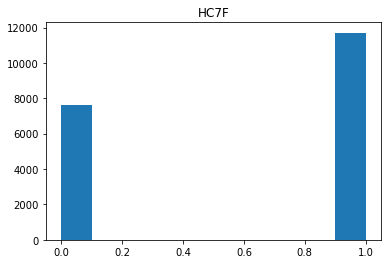

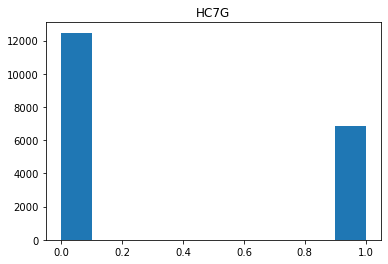

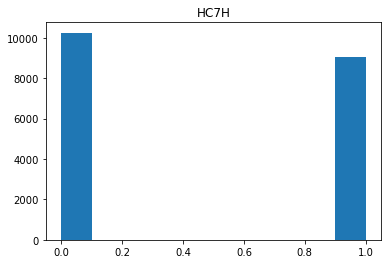

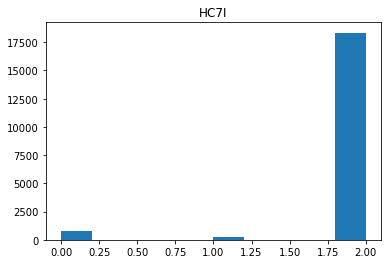

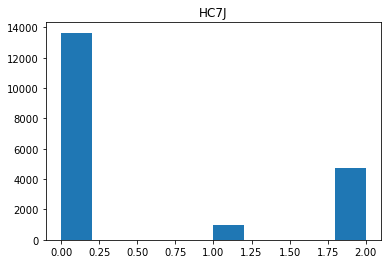

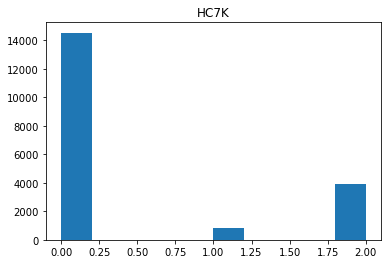

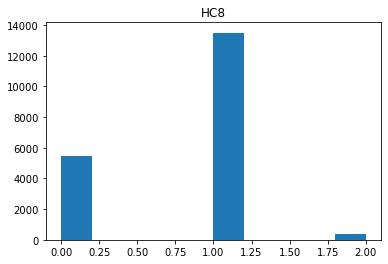

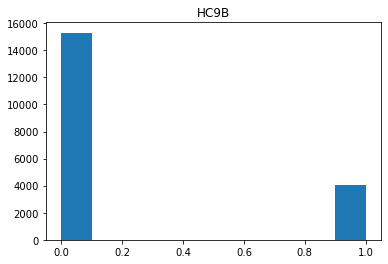

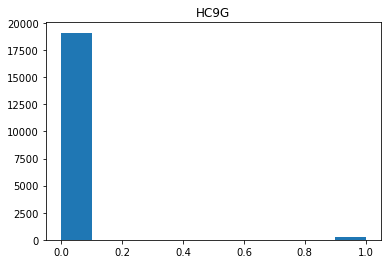

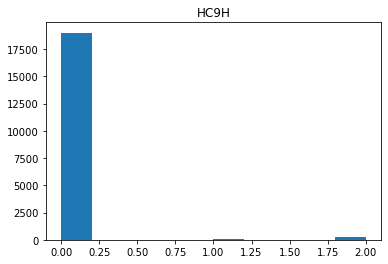

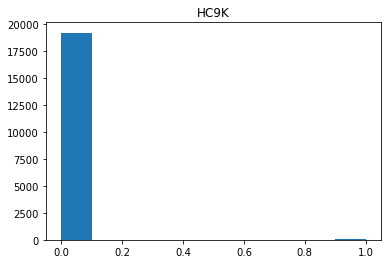

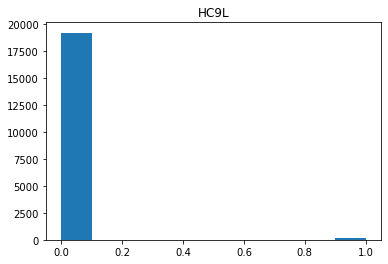

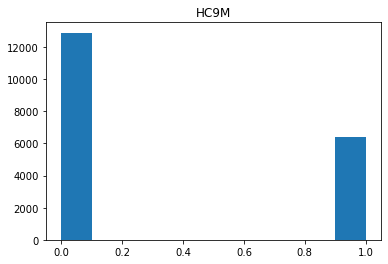

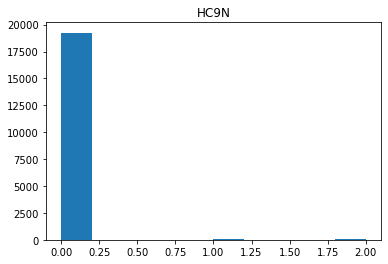

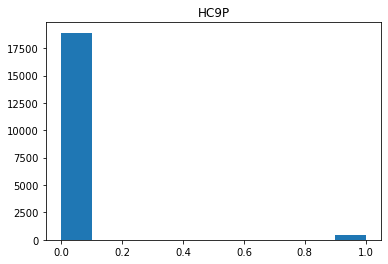

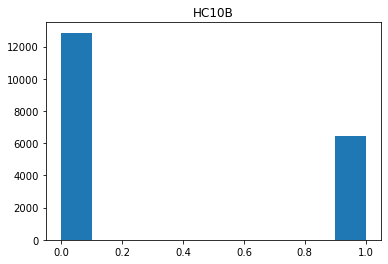

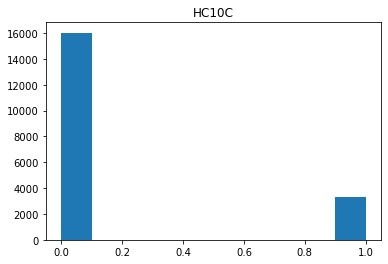

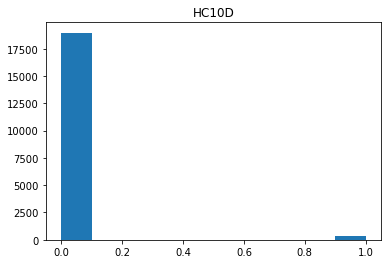

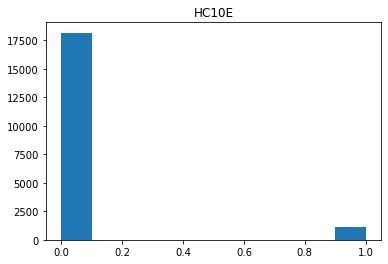

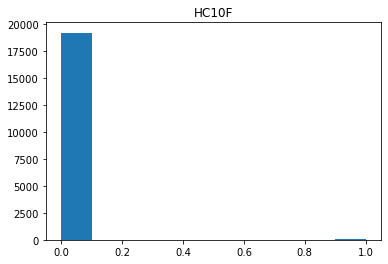

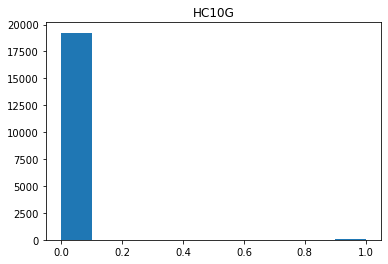

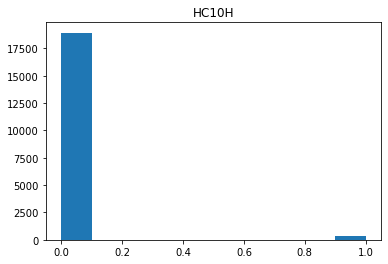

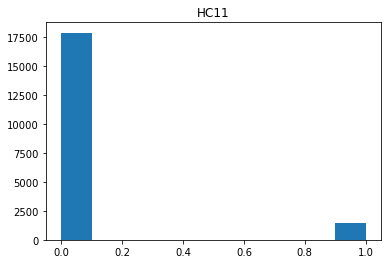

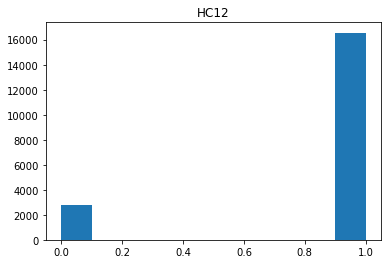

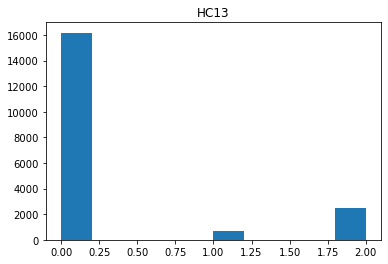

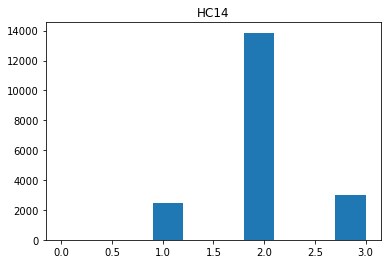

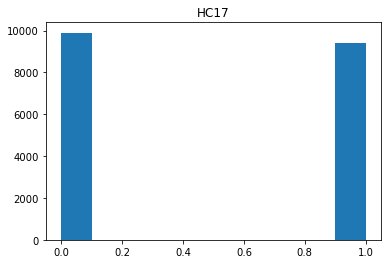

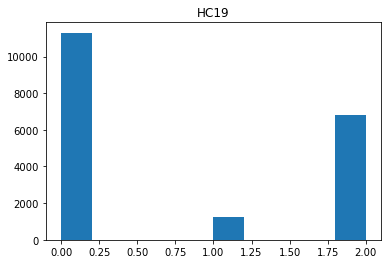

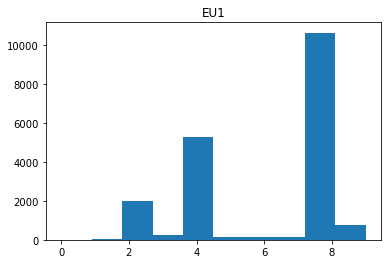

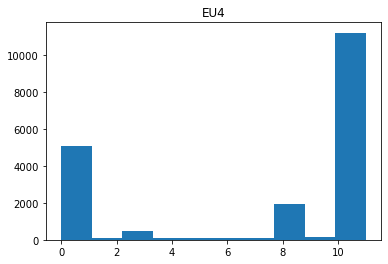

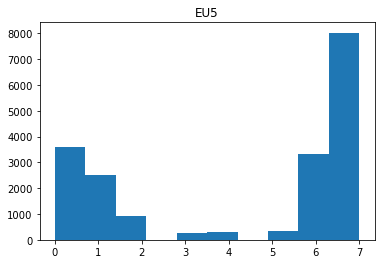

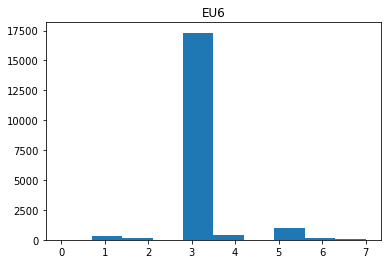

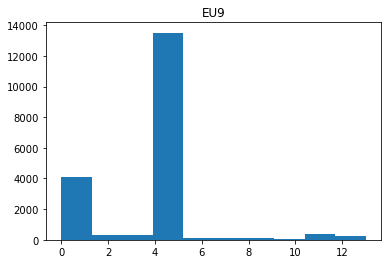

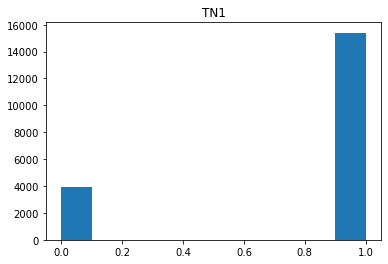

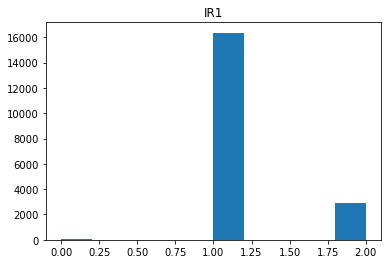

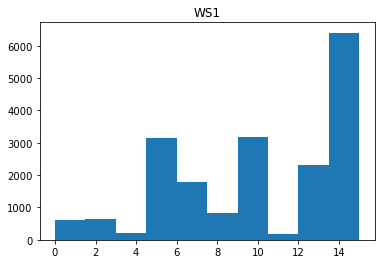

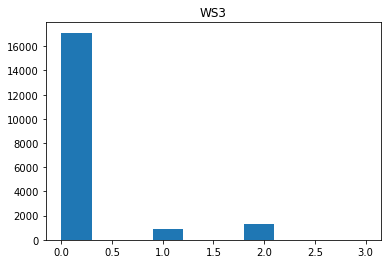

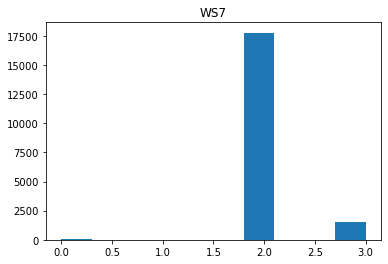

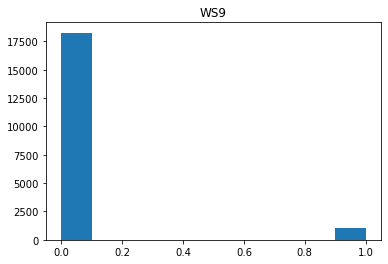

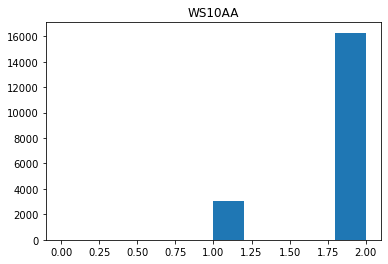

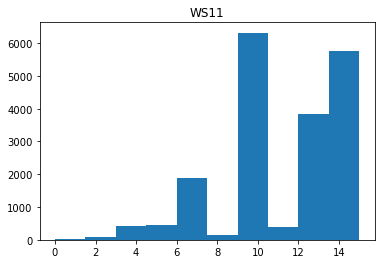

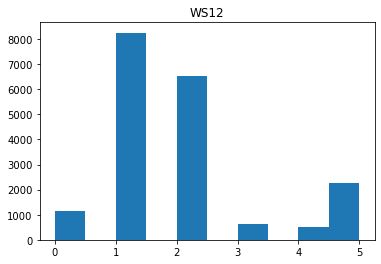

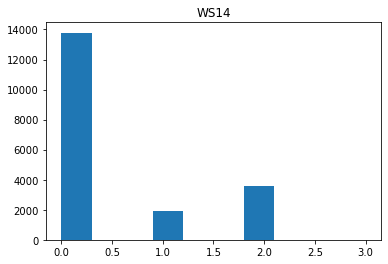

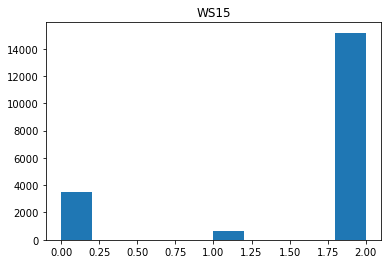

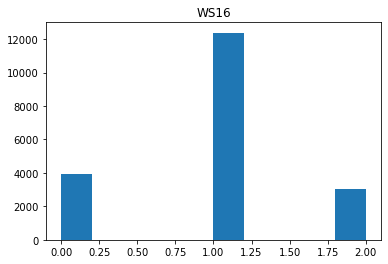

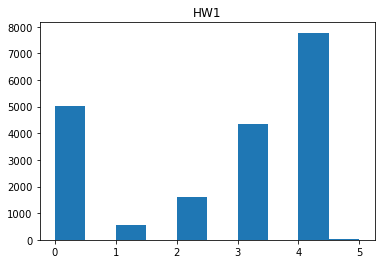

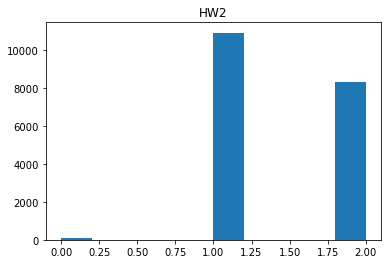

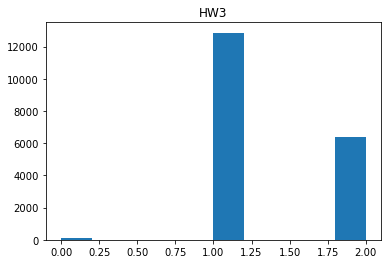

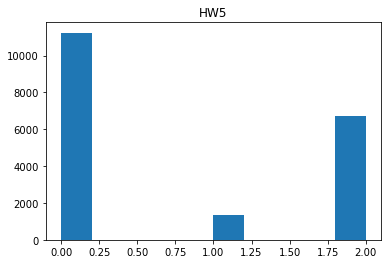

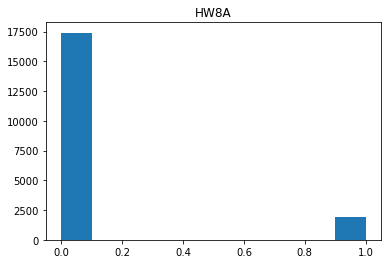

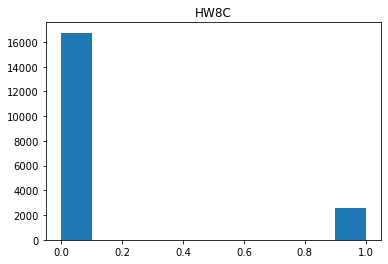

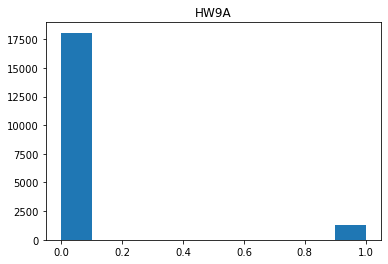

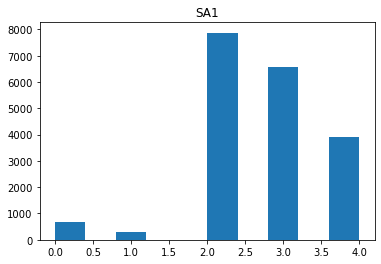

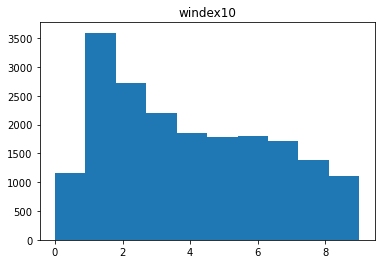

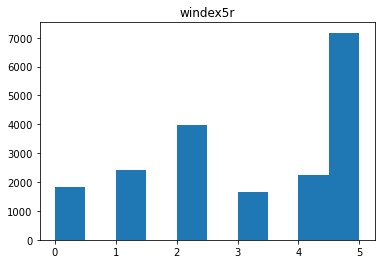

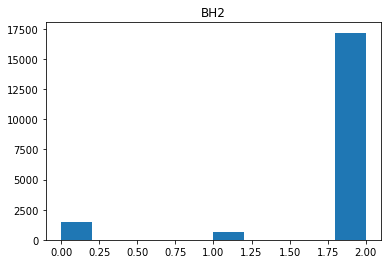

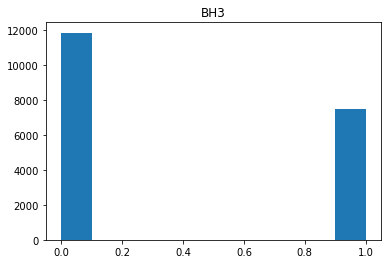

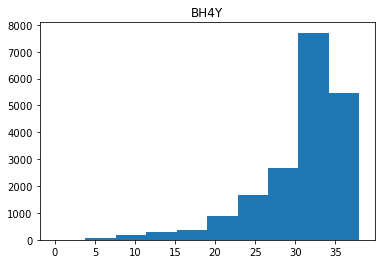

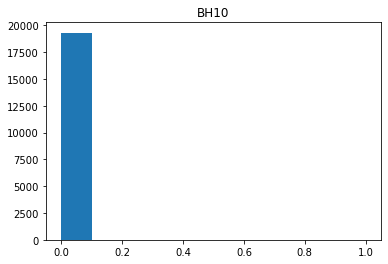

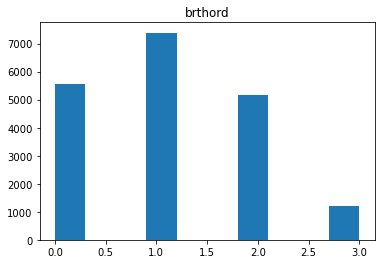

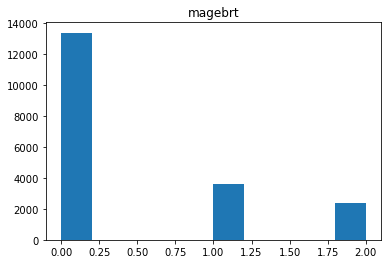

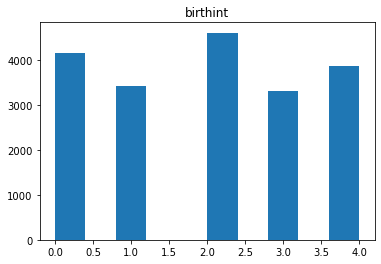

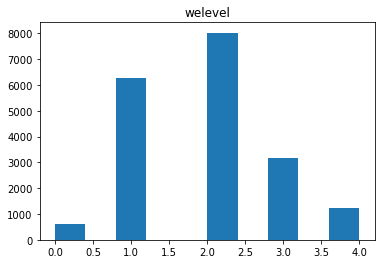

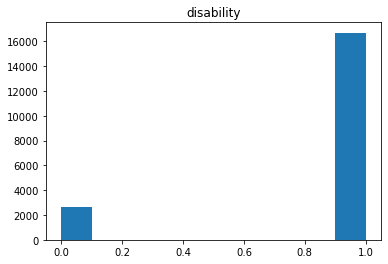

In [56]:
# fig, axis = plt.subplots(figsize=(8, 8))
# X_adasyn.hist(subplots=True,layout=(15,5), figsize=(8, 8))
for i in X_adasyn.columns:
    plt.figure()
#     print(i)
    plt.hist(X_adasyn[i])
    plt.title(i)

### Selecting features using chi2 test

Feature 0: 1392.946873
Feature 1: 72.365486
Feature 2: 24.078791
Feature 3: 6.249670
Feature 4: 85.454412
Feature 5: 43.869172
Feature 6: 0.952750
Feature 7: 0.776268
Feature 8: 0.746119
Feature 9: 102.417396
Feature 10: 205.389597
Feature 11: 134.086583
Feature 12: 0.049418
Feature 13: 115.994008
Feature 14: 113.000140
Feature 15: 42.345319
Feature 16: 235.685093
Feature 17: 59.506708
Feature 18: 34.571527
Feature 19: 14.402642
Feature 20: 29.403182
Feature 21: 262.055904
Feature 22: 4.632980
Feature 23: 110.583792
Feature 24: 48.564234
Feature 25: 137.240153
Feature 26: 35.979872
Feature 27: 137.352318
Feature 28: 6.643990
Feature 29: 29.707111
Feature 30: 57.610566
Feature 31: 269.294089
Feature 32: 16.372220
Feature 33: 323.363155
Feature 34: 40.287224
Feature 35: 39.318324
Feature 36: 213.904744
Feature 37: 28.303632
Feature 38: 30.418774
Feature 39: 25.496832
Feature 40: 0.362842
Feature 41: 25.938930
Feature 42: 50.037000
Feature 43: 0.546935
Feature 44: 13.236036
Feature 45: 79

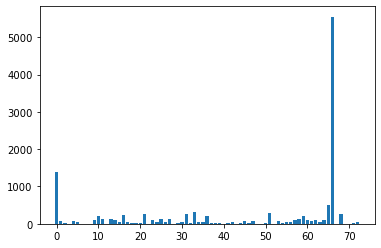

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_adasyn,
                                                      y_adasyn,
                                                      test_size=0.3,
                                                      random_state=50)
chi2_fs = SelectKBest(score_func=chi2, k=15)
chi2_fs.fit(X_train, y_train)
X_train_fs = chi2_fs.transform(X_train)
X_test_fs = chi2_fs.transform(X_test)
for i in range(len(chi2_fs.scores_)):
    print('Feature %d: %f' % (i, chi2_fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(chi2_fs.scores_))], chi2_fs.scores_)
plt.show()

### Selecting features using RandomForest

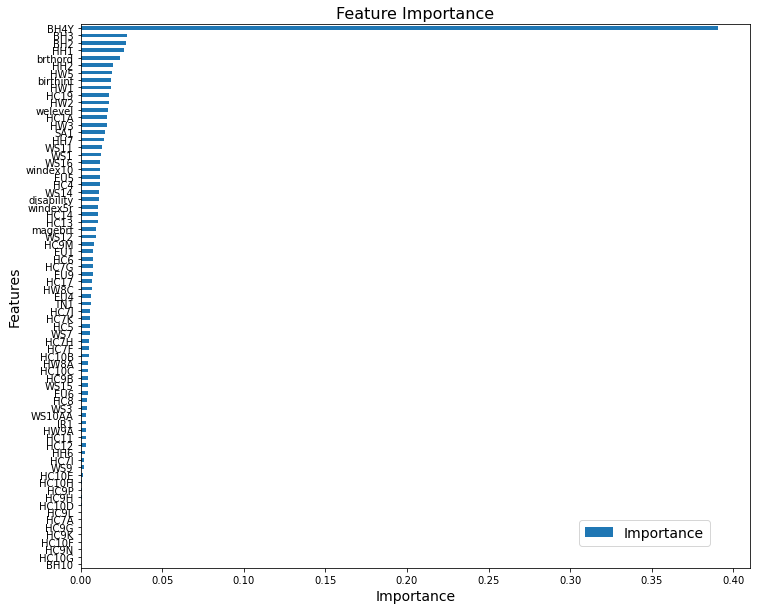

In [58]:
rf_fs = RandomForestClassifier(random_state=1)
rf_fs.fit(X_adasyn,y_adasyn)
importance = list(rf_fs.feature_importances_)
colum = list(X_adasyn.columns)

feature_importance = pd.DataFrame(zip(colum, importance), columns=['Feature', 'Importance']).sort_values('Importance')

feature_importance = feature_importance.set_index('Feature')

feature_importance.plot(kind='barh', figsize=(12,10))
plt.title('Feature Importance', fontsize=16)
plt.legend(bbox_to_anchor=(0.95, 0.1), fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.show()



In [59]:
cols_to_feature = list(feature_importance.sort_values(by='Importance', ascending=False).head(15).index)

In [60]:
featured_df_rf = X_adasyn[cols_to_feature]

In [61]:
# fig, axes = plt.subplots(len(featured_df_rf.columns)//3, 3, figsize=(20, 30))

# i = 0
# for triaxis in axes:
#     for axis in triaxis:
#         featured_df_rf.hist(column = featured_df_rf.columns[i], ax=axis)
#         i = i+1

In [62]:
X_train_rf_fs, X_test_rf_fs, y_train, y_test = train_test_split(featured_df_rf,
                                                          y_adasyn,
                                                          test_size=0.3,
                                                          random_state=50)

## Model Implementation and comparison

### CATBoost

#### Features Selected by Chi2

In [63]:

cat_features = list(range(0, X_train_fs.shape[1]))
clf = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
    random_state = 10
)


clf.fit(X_train_fs, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test_fs, y_test), 
        verbose=False,
        plot=True
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
y_pred_catboost = clf.predict(data = X_test_fs)
acc_catboost = metrics.accuracy_score(y_test, y_pred_catboost)
f1_score_catboost = metrics.f1_score(y_test, y_pred_catboost)
recall_score_catboostt = metrics.recall_score(y_test, y_pred_catboost)
precision_score_catboostt = metrics.precision_score(y_test, y_pred_catboost)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 50, 'learning_rate': 0.3, 'loss_function': 'CrossEntropy', 'random_state': 10}


In [64]:
acc_catboost, f1_score_catboost, recall_score_catboostt, precision_score_catboostt

(0.8935839944808555,
 0.9024505928853754,
 0.9684424838819138,
 0.8448786264061575)

In [65]:
y_pred_prob = clf.predict_proba(data = X_test_fs)

In [66]:
pd.DataFrame(confusion_matrix(y_test, y_pred_catboost))

,0,1
0,2327,524
1,93,2854


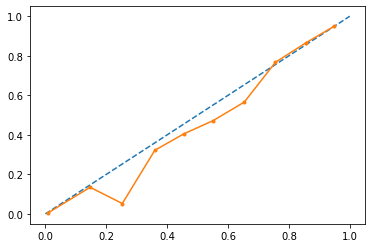

In [68]:
fop, mpv = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

#### Features Selected by Random Forest

In [69]:
cat_features = list(range(0, X_train_rf_fs.shape[1]))
clf = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
    random_state=10
)


clf.fit(X_train_rf_fs, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test_rf_fs, y_test), 
        verbose=False,
        plot=True
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
y_pred_catboost_rf = clf.predict(data = X_test_rf_fs)
acc_catboost_rf = metrics.accuracy_score(y_test, y_pred_catboost_rf)
f1_score_catboost_rf = metrics.f1_score(y_test, y_pred_catboost_rf)
recall_score_catboost_rf = metrics.recall_score(y_test, y_pred_catboost_rf)
precision_score_catboost_rf = metrics.precision_score(y_test, y_pred_catboost_rf)

acc_catboost_rf,f1_score_catboost_rf, recall_score_catboost_rf, precision_score_catboost_rf

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 50, 'learning_rate': 0.3, 'loss_function': 'CrossEntropy', 'random_state': 10}


(0.9394618834080718, 0.9426564286881227, 0.9789616559212758, 0.908947700063012)

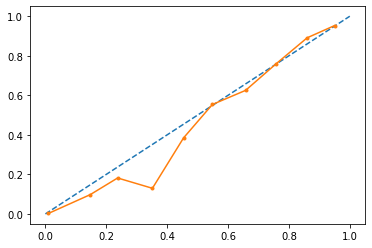

In [70]:
y_pred_prob = clf.predict_proba(data = X_test_rf_fs)
fop, mpv = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

### KNN

#### Features Selected by Chi2

In [71]:
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets

knn.fit(X_train_fs, y_train)
y_pred_knn_fs = knn.predict(X_test_fs)
acc_knn_fs = metrics.accuracy_score(y_test, y_pred_knn_fs)
f1_score_knn_fs = metrics.f1_score(y_test, y_pred_knn_fs)
recall_score_knn_fs = metrics.recall_score(y_test, y_pred_knn_fs)
precision_score_knn_fs = metrics.precision_score(y_test, y_pred_knn_fs)
acc_knn_fs,f1_score_knn_fs, recall_score_knn_fs, precision_score_knn_fs

(0.8820282856157295, 0.8784216139353005, 0.838479809976247, 0.9223590892123927)

In [72]:
y_pred_prob = knn.predict_proba(X_test_fs)
knn = KNeighborsClassifier(n_neighbors=3)
cal_knn = CalibratedClassifierCV(knn, cv=5)
cal_knn.fit(X_train_fs, y_train)
y_pred_cal = cal_knn.predict_proba(X_test_fs)

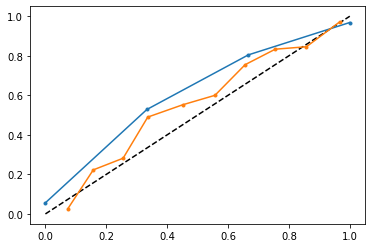

In [73]:

fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [74]:

y_pred_knn_fs_cal = cal_knn.predict(X_test_fs)
acc_knn_fs_cal = metrics.accuracy_score(y_test, y_pred_knn_fs_cal)
f1_score_knn_fs_cal = metrics.f1_score(y_test, y_pred_knn_fs_cal)
recall_score_knn_fs_cal = metrics.recall_score(y_test, y_pred_knn_fs_cal)
precision_score_knn_fs_cal = metrics.precision_score(y_test, y_pred_knn_fs_cal)
acc_knn_fs_cal,f1_score_knn_fs_cal, recall_score_knn_fs_cal, precision_score_knn_fs_cal

(0.8880648499482581,
 0.8881998277347114,
 0.8747879199185612,
 0.9020293911826452)

#### Features Selected by Random Forest

In [75]:
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train_rf_fs, y_train)
y_pred_knn_fs = knn.predict(X_test_rf_fs)
acc_knn_fs = metrics.accuracy_score(y_test, y_pred_knn_fs)
f1_score_knn_fs = metrics.f1_score(y_test, y_pred_knn_fs)
recall_knn_fs = metrics.recall_score(y_test, y_pred_knn_fs)
precision_score_knn_fs = metrics.precision_score(y_test, y_pred_knn_fs)
acc_knn_fs,f1_score_knn_fs, recall_score_knn_fs, precision_score_knn_fs

(0.903242497412901, 0.8977210574293526, 0.838479809976247, 0.9700551615445232)

In [76]:
y_pred_prob = knn.predict_proba(X_test_fs)
knn = KNeighborsClassifier(n_neighbors=3)
cal_knn = CalibratedClassifierCV(knn, cv=5)
cal_knn.fit(X_train_rf_fs, y_train)
y_pred_cal = cal_knn.predict_proba(X_test_rf_fs)

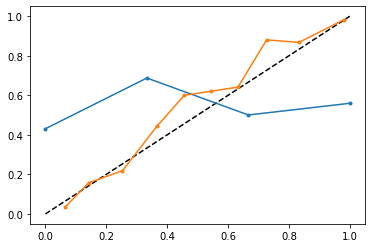

In [77]:
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [78]:
y_pred_knn_rf_fs_cal = cal_knn.predict(X_test_rf_fs)
acc_knn_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_knn_rf_fs_cal)
f1_score_knn_rf_fs_cal = metrics.f1_score(y_test, y_pred_knn_rf_fs_cal)
recall_knn_rf_fs_cal = metrics.recall_score(y_test, y_pred_knn_rf_fs_cal)
precision_score_knn_rf_fs_cal = metrics.precision_score(y_test, y_pred_knn_rf_fs_cal)
acc_knn_rf_fs_cal,f1_score_knn_rf_fs_cal, recall_knn_rf_fs_cal, precision_score_knn_rf_fs_cal

(0.9118661607450845,
 0.9099876695437731,
 0.8764845605700713,
 0.9461538461538461)

### RandomForest

#### Features Selected by Chi2

In [79]:
rf_model = RandomForestClassifier(n_estimators=1000, 
                               random_state=50)

# Fit on training data
rf_model.fit(X_train_fs, y_train)
y_pred_rf_fs = rf_model.predict(X_test_fs)
acc_rf_fs = metrics.accuracy_score(y_test, y_pred_rf_fs)
f1_score_rf_fs = metrics.f1_score(y_test, y_pred_rf_fs)
recall_score_rf_fs = metrics.recall_score(y_test, y_pred_rf_fs)
precision_score_rf_fs = metrics.precision_score(y_test, y_pred_rf_fs)
acc_rf_fs,f1_score_rf_fs, recall_score_rf_fs, precision_score_rf_fs

(0.9251466022766471, 0.927400468384075, 0.9406175771971497, 0.9145496535796767)

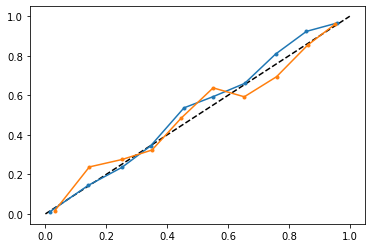

In [80]:
y_pred_prob = rf_model.predict_proba(X_test_fs) 

rf_model = RandomForestClassifier(n_estimators=1000, random_state=50)

rf_model_cal = CalibratedClassifierCV(rf_model, cv=5)
rf_model_cal.fit(X_train_fs, y_train)
y_pred_cal = rf_model_cal.predict_proba(X_test_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [81]:
y_pred_rf_fs_cal = rf_model_cal.predict(X_test_fs)
acc_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_rf_fs_cal)
f1_score_rf_fs_cal = metrics.f1_score(y_test, y_pred_rf_fs_cal)
recall_score_rf_fs_cal = metrics.recall_score(y_test, y_pred_rf_fs_cal)
precision_score_rf_fs_cal = metrics.precision_score(y_test, y_pred_rf_fs_cal)
acc_rf_fs_cal,f1_score_rf_fs_cal, recall_score_rf_fs_cal, precision_score_rf_fs_cal

(0.9263539151431528,
 0.9285833751463455,
 0.9419748897183576,
 0.9155672823218998)

#### Features Selected by RandomForest

In [82]:
rf_model = RandomForestClassifier(n_estimators=1000, 
                               random_state=50)
rf_model.fit(X_train_rf_fs, y_train)
y_pred_rf_ran_fs = rf_model.predict(X_test_rf_fs)
acc_rf_ran_fs = metrics.accuracy_score(y_test, y_pred_rf_ran_fs)
f1_score_rf_ran_fs = metrics.f1_score(y_test, y_pred_rf_ran_fs)
recall_score_rf_ran_fs = metrics.recall_score(y_test, y_pred_rf_ran_fs)
precision_score_rf_ran_fs = metrics.precision_score(y_test, y_pred_rf_ran_fs)
acc_rf_ran_fs,f1_score_rf_ran_fs, recall_score_rf_ran_fs, precision_score_rf_ran_fs

(0.9560193170058641, 0.9576903932304628, 0.9793009840515778, 0.937012987012987)

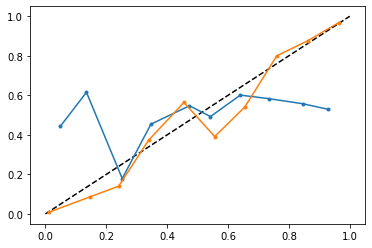

In [83]:
y_pred_prob = rf_model.predict_proba(X_test_fs) 

rf_model = RandomForestClassifier(n_estimators=1000, random_state=50)

rf_model_cal = CalibratedClassifierCV(rf_model, cv=5)
rf_model_cal.fit(X_train_rf_fs, y_train)
y_pred_cal = rf_model_cal.predict_proba(X_test_rf_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [84]:
y_pred_rf_ran_fs_cal = rf_model_cal.predict(X_test_rf_fs)
acc_rf_ran_fs_cal = metrics.accuracy_score(y_test, y_pred_rf_ran_fs_cal)
f1_score_rf_ran_fs_cal = metrics.f1_score(y_test, y_pred_rf_ran_fs_cal)
recall_score_rf_ran_fs_cal = metrics.recall_score(y_test, y_pred_rf_ran_fs_cal)
precision_score_rf_ran_fs_cal = metrics.precision_score(y_test, y_pred_rf_ran_fs_cal)
acc_rf_ran_fs_cal,f1_score_rf_ran_fs_cal, recall_score_rf_ran_fs_cal, precision_score_rf_ran_fs_cal

(0.9548120041393584, 0.956318772924308, 0.9731930777061418, 0.9400196656833825)

### XGBoost

#### Features Selected by Chi2

In [85]:
xgb_model = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=100,
     max_depth=5,
     objective= 'binary:logistic',
    random_state=10
)
eval_set = [(X_train_fs, y_train),(X_test_fs, y_test)]
xgb_model.fit(X_train_fs, y_train,early_stopping_rounds=10, eval_metric=["error", 'logloss'], eval_set=eval_set, verbose=False)

y_pred_xgb_fs = xgb_model.predict(X_test_fs)

acc_xgb_fs = metrics.accuracy_score(y_test, y_pred_xgb_fs)

f1_score_xgb_fs = metrics.f1_score(y_test, y_pred_xgb_fs)

recall_score_xgb_fs = metrics.recall_score(y_test, y_pred_xgb_fs)

precision_score_xgb_fs = metrics.precision_score(y_test, y_pred_xgb_fs)

acc_xgb_fs,f1_score_xgb_fs, recall_score_xgb_fs, precision_score_xgb_fs

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9051397033459814,
 0.9120562839782538,
 0.9677638276213099,
 0.8624130631992742)

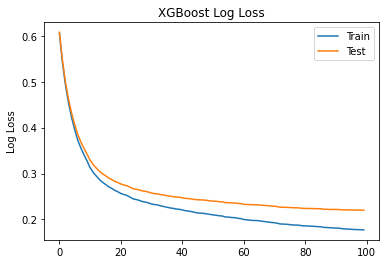

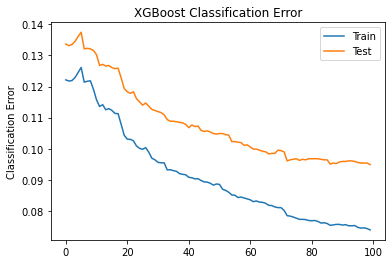

In [86]:
results_ch2 = xgb_model.evals_result()
epochs = len(results_ch2['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results_ch2['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results_ch2['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results_ch2['validation_0']['error'], label='Train')
ax.plot(x_axis, results_ch2['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[04:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


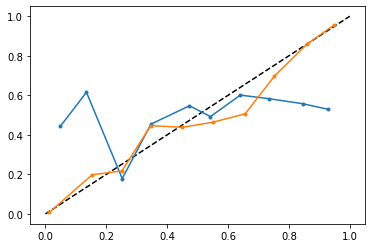

In [87]:
xgb_model = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=100,
     max_depth=5,
     objective= 'binary:logistic',
    random_state=10
)

xg_boost_cal = CalibratedClassifierCV(xgb_model, cv=5)
xg_boost_cal.fit(X_train_fs, y_train)
y_pred_cal = xg_boost_cal.predict_proba(X_test_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [88]:
y_pred_xg_fs_cal = xg_boost_cal.predict(X_test_fs)
acc_xg_fs_cal = metrics.accuracy_score(y_test, y_pred_xg_fs_cal)
f1_score_xg_fs_cal = metrics.f1_score(y_test, y_pred_xg_fs_cal)
recall_score_xg_fs_cal = metrics.recall_score(y_test, y_pred_xg_fs_cal)
precision_score_xg_fs_cal = metrics.precision_score(y_test, y_pred_xg_fs_cal)
acc_xg_fs_cal,f1_score_xg_fs_cal, recall_score_xg_fs_cal, precision_score_xg_fs_cal

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9091065884787858,
 0.9140994295028525,
 0.9514760773668137,
 0.8795483061480552)

#### Features Selected by RandomForest

In [89]:
xgb_model = xgb.XGBClassifier(
 learning_rate =0.15,
 n_estimators=100,
 max_depth=5,
 objective= 'binary:logistic',
 seed=27,
 random_state=10
)
eval_set = [(X_train_rf_fs, y_train),(X_test_rf_fs, y_test)]

xgb_model.fit(X_train_rf_fs, y_train, early_stopping_rounds=10, eval_metric=["error", 'logloss'], eval_set=eval_set, verbose=False)

y_pred_xgb_rf_fs = xgb_model.predict(X_test_rf_fs)

acc_xgb_rf_fs = metrics.accuracy_score(y_test, y_pred_xgb_rf_fs)

f1_score_xgb_rf_fs = metrics.f1_score(y_test, y_pred_xgb_rf_fs)

recall_score_xgb_rf_fs = metrics.recall_score(y_test, y_pred_xgb_rf_fs)

precision_score_xgb_rf_fs = metrics.precision_score(y_test, y_pred_xgb_rf_fs)

acc_xgb_rf_fs,f1_score_xgb_rf_fs, recall_score_xgb_rf_fs, precision_score_xgb_rf_fs

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9454984477406002,
 0.9483491337038247,
 0.9843909060061079,
 0.9148533585619678)

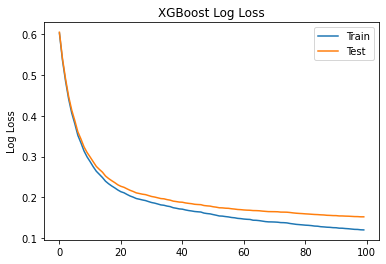

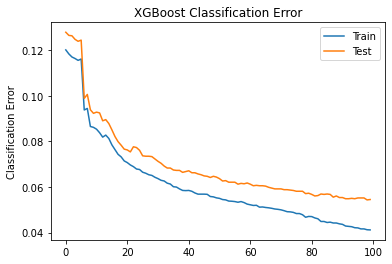

In [90]:
# xgb_model.evals_result()
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[04:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


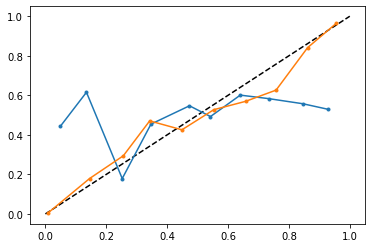

In [91]:
xgb_model = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=100,
     max_depth=5,
     objective= 'binary:logistic',
    random_state=10
)

xg_boost_cal = CalibratedClassifierCV(xgb_model, cv=5)
xg_boost_cal.fit(X_train_rf_fs, y_train)
y_pred_cal = xg_boost_cal.predict_proba(X_test_rf_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [92]:
y_pred_xg_rf_fs_cal = xg_boost_cal.predict(X_test_rf_fs)
acc_xg_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_xg_rf_fs_cal)
f1_score_xg_rf_fs_cal = metrics.f1_score(y_test, y_pred_xg_rf_fs_cal)
recall_score_xg_rf_fs_cal = metrics.recall_score(y_test, y_pred_xg_rf_fs_cal)
precision_score_xg_rf_fs_cal = metrics.precision_score(y_test, y_pred_xg_rf_fs_cal)
acc_xg_rf_fs_cal,f1_score_xg_rf_fs_cal, recall_score_xg_rf_fs_cal, precision_score_xg_rf_fs_cal

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9467057606071059,
 0.9489677952105697,
 0.9748897183576518,
 0.9243886743886743)

### Logistic Regression

#### Features Selected by Chi2

In [93]:
log = LogisticRegression(random_state=10)
log.fit(X_train_fs, y_train)
y_pred_log_fs = log.predict(X_test_fs)
acc_log_fs = metrics.accuracy_score(y_test, y_pred_log_fs)
f1_score_log_fs = metrics.f1_score(y_test, y_pred_log_fs)
recall_score_log_fs = metrics.recall_score(y_test, y_pred_log_fs)
precision_score_log_fs = metrics.precision_score(y_test, y_pred_log_fs)
acc_log_fs,f1_score_log_fs, recall_score_log_fs, precision_score_log_fs

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.8313211452224906,
 0.8387203166226913,
 0.8629114353579912,
 0.8158485723452037)

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

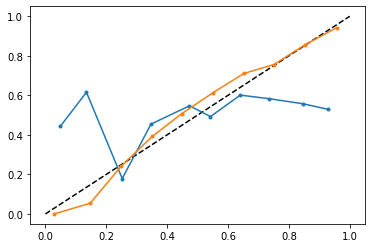

In [94]:
log = LogisticRegression(random_state=10)
log_cal = CalibratedClassifierCV(log, cv=4)
log_cal.fit(X_train_fs, y_train)
y_pred_cal = log_cal.predict_proba(X_test_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [95]:
y_pred_log_fs_cal = log_cal.predict(X_test_fs)
acc_log_fs_cal = metrics.accuracy_score(y_test, y_pred_log_fs_cal)
f1_score_log_fs_cal = metrics.f1_score(y_test, y_pred_log_fs_cal)
recall_score_log_fs_cal = metrics.recall_score(y_test, y_pred_log_fs_cal)
precision_score_log_fs_cal = metrics.precision_score(y_test, y_pred_log_fs_cal)
acc_log_fs_cal,f1_score_log_fs_cal, recall_score_log_fs_cal, precision_score_log_fs_cal

(0.8318385650224215, 0.839188520534389, 0.8632507634882932, 0.8164313222079589)

#### Features Selected by RandomForest

In [96]:
log = LogisticRegression(random_state=10)
log.fit(X_train_rf_fs, y_train)
y_pred_log_rf_fs = log.predict(X_test_rf_fs)
acc_log_rf_fs = metrics.accuracy_score(y_test, y_pred_log_rf_fs)
f1_score_log_rf_fs = metrics.f1_score(y_test, y_pred_log_rf_fs)
recall_score_log_rf_fs = metrics.recall_score(y_test, y_pred_log_rf_fs)
precision_score_log_rf_fs = metrics.precision_score(y_test, y_pred_log_rf_fs)
acc_log_rf_fs,f1_score_log_rf_fs, recall_score_log_rf_fs, precision_score_log_rf_fs

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.6973094170403588,
 0.7102526002971767,
 0.7298948082796064,
 0.6916398713826366)

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

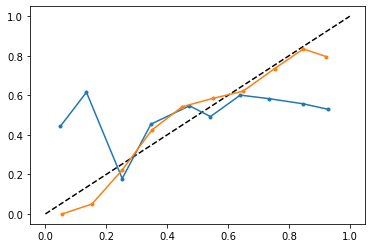

In [97]:
log = LogisticRegression(random_state=10)
log_cal = CalibratedClassifierCV(log, cv=4)
log_cal.fit(X_train_rf_fs, y_train)
y_pred_cal = log_cal.predict_proba(X_test_rf_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [98]:
y_pred_log_rf_fs_cal = log_cal.predict(X_test_rf_fs)
acc_log_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_log_rf_fs_cal)
f1_score_log_rf_fs_cal = metrics.f1_score(y_test, y_pred_log_rf_fs_cal)
recall_score_log_rf_fs_cal = metrics.recall_score(y_test, y_pred_log_rf_fs_cal)
precision_score_log_rf_fs_cal = metrics.precision_score(y_test, y_pred_log_rf_fs_cal)
acc_log_rf_fs_cal,f1_score_log_rf_fs_cal, recall_score_log_rf_fs_cal, precision_score_log_rf_fs_cal

(0.6997240427733701,
 0.7067542529897254,
 0.7119104173736003,
 0.7016722408026755)

### Result Comparison

In [99]:

results_dict = {'Model':['CatBoost', 'KNN', 'RandomForest', 'XGBoost', 'LogisticRegression']*2,
                'Feature Selection':['Chi2', 'RandomForest']*5,
                'Accuracy':[acc_catboost
            ,acc_catboost_rf
            ,acc_knn_fs_cal
            ,acc_knn_rf_fs_cal
            ,acc_rf_fs_cal
            ,acc_rf_ran_fs
            ,acc_xg_fs_cal
            ,acc_xg_rf_fs_cal
            ,acc_log_fs_cal
            ,acc_log_rf_fs_cal],
            'F1 Score':[f1_score_catboost
            ,f1_score_catboost_rf
            ,f1_score_knn_fs_cal
            ,f1_score_knn_rf_fs_cal
            ,f1_score_rf_fs_cal
            ,f1_score_rf_ran_fs
            ,f1_score_xg_fs_cal
            ,f1_score_xg_rf_fs_cal
            ,f1_score_log_fs_cal
            ,f1_score_log_rf_fs_cal],
            'Precision':[precision_score_catboostt
            ,precision_score_catboost_rf
            ,precision_score_knn_fs_cal
            ,precision_score_knn_rf_fs_cal
            ,precision_score_rf_fs_cal
            ,precision_score_rf_ran_fs
            ,precision_score_xg_fs_cal
            ,precision_score_xgb_rf_fs
            ,precision_score_log_fs_cal
            ,precision_score_log_rf_fs_cal],
            'Recall':[recall_score_catboostt
            ,recall_score_catboost_rf
            ,recall_score_knn_fs_cal
            ,recall_knn_rf_fs_cal
            ,recall_score_rf_fs_cal
            ,recall_score_rf_ran_fs
            ,recall_score_xg_fs_cal
            ,recall_score_xg_rf_fs_cal
            ,recall_score_log_fs_cal
            ,recall_score_log_rf_fs_cal]
         }



In [100]:
results = pd.DataFrame(results_dict)

In [101]:
results.sort_values(by=['F1 Score'], ascending=False)

,Model,Feature Selection,Accuracy,F1 Score,Precision,Recall
5,CatBoost,RandomForest,0.956019,0.957690,0.937013,0.979301
7,RandomForest,RandomForest,0.946706,0.948968,0.914853,0.974890
1,KNN,RandomForest,0.939462,0.942656,0.908948,0.978962
4,LogisticRegression,Chi2,0.926354,0.928583,0.915567,0.941975
6,KNN,Chi2,0.909107,0.914099,0.879548,0.951476
3,XGBoost,RandomForest,0.911866,0.909988,0.946154,0.876485
0,CatBoost,Chi2,0.893584,0.902451,0.844879,0.968442
2,RandomForest,Chi2,0.888065,0.888200,0.902029,0.874788
8,XGBoost,Chi2,0.831839,0.839189,0.816431,0.863251
9,LogisticRegression,RandomForest,0.699724,0.706754,0.701672,0.711910


In [102]:
results.set_index(['Model','Feature Selection'], inplace=True)

In [103]:
results

,,Accuracy,F1 Score,Precision,Recall
Model,Feature Selection,,,,
CatBoost,Chi2,0.893584,0.902451,0.844879,0.968442
KNN,RandomForest,0.939462,0.942656,0.908948,0.978962
RandomForest,Chi2,0.888065,0.888200,0.902029,0.874788
XGBoost,RandomForest,0.911866,0.909988,0.946154,0.876485
LogisticRegression,Chi2,0.926354,0.928583,0.915567,0.941975
CatBoost,RandomForest,0.956019,0.957690,0.937013,0.979301
KNN,Chi2,0.909107,0.914099,0.879548,0.951476
RandomForest,RandomForest,0.946706,0.948968,0.914853,0.974890
XGBoost,Chi2,0.831839,0.839189,0.816431,0.863251


<AxesSubplot:>

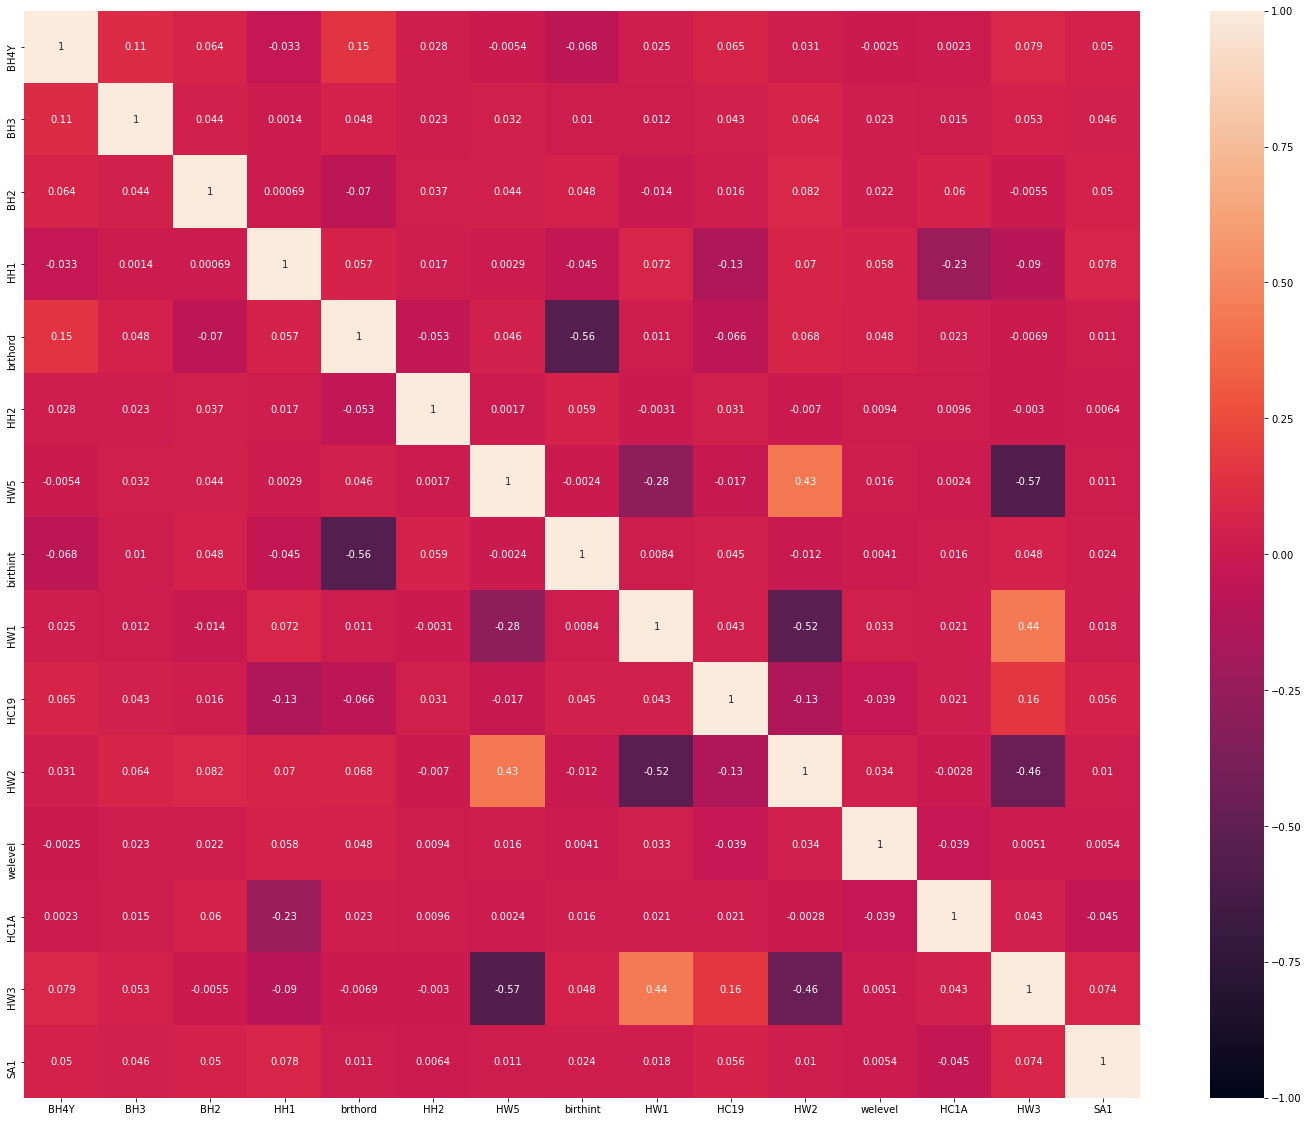

In [104]:
# X_train_rf_fs.corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 20))
sns.heatmap(X_train_rf_fs.corr(), vmin=-1, vmax=1, annot=True)

In [105]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#### ROC Curves

0:	learn: 0.5245143	total: 3.47ms	remaining: 170ms
1:	learn: 0.4329376	total: 6.5ms	remaining: 156ms
2:	learn: 0.3769977	total: 9.46ms	remaining: 148ms
3:	learn: 0.3380259	total: 12ms	remaining: 138ms
4:	learn: 0.3066382	total: 14.7ms	remaining: 132ms
5:	learn: 0.2835751	total: 17.6ms	remaining: 129ms
6:	learn: 0.2681529	total: 20.7ms	remaining: 127ms
7:	learn: 0.2503356	total: 23.5ms	remaining: 123ms
8:	learn: 0.2384029	total: 26.1ms	remaining: 119ms
9:	learn: 0.2288426	total: 28.6ms	remaining: 114ms
10:	learn: 0.2205083	total: 31.3ms	remaining: 111ms
11:	learn: 0.2144858	total: 33.9ms	remaining: 107ms
12:	learn: 0.2113217	total: 36.5ms	remaining: 104ms
13:	learn: 0.2077151	total: 38.9ms	remaining: 100ms
14:	learn: 0.2051163	total: 41.5ms	remaining: 96.8ms
15:	learn: 0.2013949	total: 43.9ms	remaining: 93.3ms
16:	learn: 0.1973217	total: 46.5ms	remaining: 90.2ms
17:	learn: 0.1943693	total: 49.3ms	remaining: 87.6ms
18:	learn: 0.1914502	total: 51.8ms	remaining: 84.6ms
19:	learn: 0.1907358

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.976
Random Forest: ROC AUC=0.986
XGBoost: ROC AUC=0.982
KNN: ROC AUC=0.968
Logistic Regression: ROC AUC=0.785


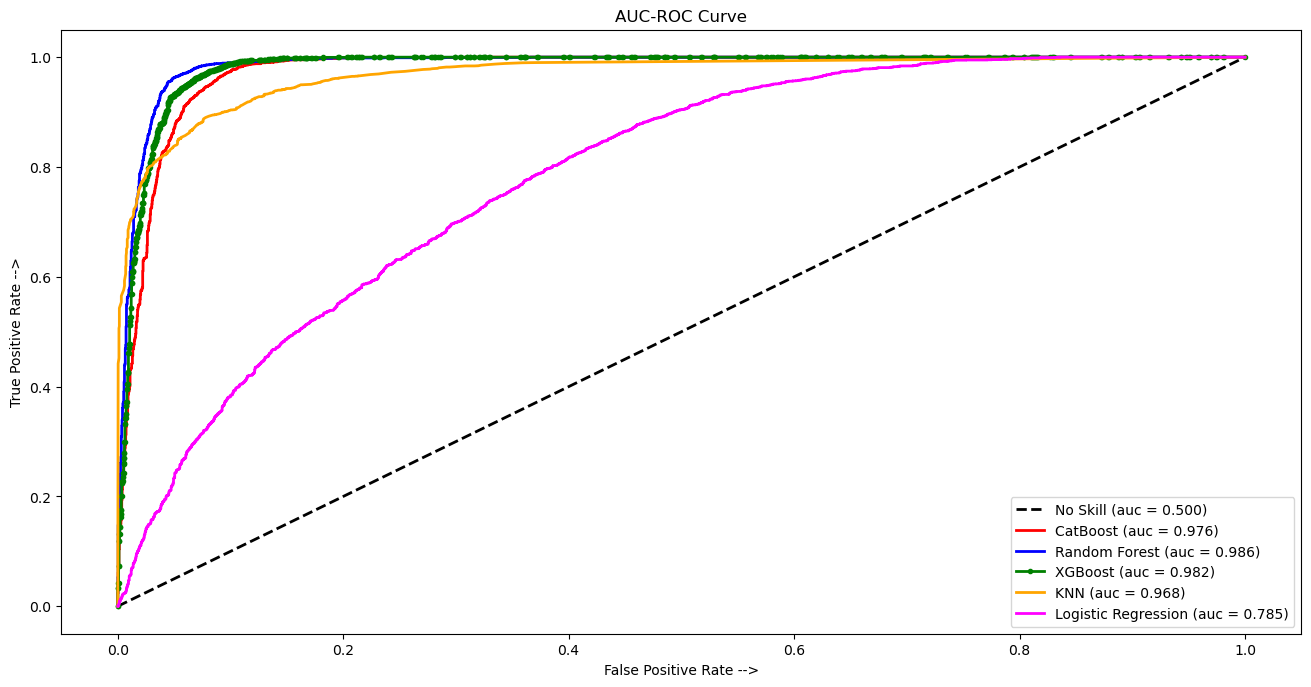

In [106]:
ns_probs = [0 for _ in range(len(y_test))]


# fit a model
SEED=1
cat_clf = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
    random_state=SEED
)
rf_clf = RandomForestClassifier(n_estimators=1000, 
                               random_state=SEED)
rf_clf = CalibratedClassifierCV(rf_clf, cv=5)
xgb_clf = xgb.XGBClassifier(
         learning_rate =0.15,
         n_estimators=100,
         max_depth=5,
         objective= 'binary:logistic',
         random_state=SEED)
xgb_clf = CalibratedClassifierCV(xgb_clf, cv=5)
knn_clf = CalibratedClassifierCV(KNeighborsClassifier() , cv=5)
log_clf = CalibratedClassifierCV(LogisticRegression(random_state=SEED), cv=4)

# trains the classifiers
cat_clf.fit(X_train_rf_fs, y_train)
rf_clf.fit(X_train_rf_fs, y_train)
xgb_clf.fit(X_train_rf_fs, y_train)
knn_clf.fit(X_train_rf_fs, y_train)
log_clf.fit(X_train_rf_fs, y_train)


# predict probabilities
cat_probs = cat_clf.predict_proba(X_test_rf_fs)
rf_probs = rf_clf.predict_proba(X_test_rf_fs)
xgb_probs = xgb_clf.predict_proba(X_test_rf_fs)
knn_probs = knn_clf.predict_proba(X_test_rf_fs)
log_probs = log_clf.predict_proba(X_test_rf_fs)

# keep probabilities for the positive outcome only
cat_probs = cat_probs[:, 1]
rf_probs = rf_probs[:, 1]
xgb_probs = xgb_probs[:, 1]
knn_probs = knn_probs[:, 1]
log_probs = log_probs[:, 1]

# calculate scores

ns_auc = roc_auc_score(y_test, ns_probs)
cat_auc = roc_auc_score(y_test, cat_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
log_auc = roc_auc_score(y_test, log_probs)


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (cat_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))
print('Logistic Regression: ROC AUC=%.3f' % (log_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)



# plot the roc curve for the model
plt.figure(figsize=(16,8), dpi=100)

plt.plot(ns_fpr, ns_tpr, linestyle='dashed', linewidth=2, color= 'black', label='No Skill (auc = %0.3f)' % ns_auc)
plt.plot(cat_fpr, cat_tpr, linestyle='-', linewidth=2, color= 'red', label='CatBoost (auc = %0.3f)' % cat_auc)
plt.plot(rf_fpr, rf_tpr, linestyle='-', linewidth=2, color= 'blue', label='Random Forest (auc = %0.3f)' % rf_auc)
plt.plot(xgb_fpr, xgb_tpr, marker='.', linewidth=2, color= 'green', label='XGBoost (auc = %0.3f)' % xgb_auc)
plt.plot(knn_fpr, knn_tpr, linestyle='-', linewidth=2, color= 'orange', label='KNN (auc = %0.3f)' % knn_auc)
plt.plot(log_fpr, log_tpr, linestyle='-', linewidth=2, color= 'magenta', label='Logistic Regression (auc = %0.3f)' % log_auc)


# axis labels
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title("AUC-ROC Curve")
plt.legend()

plt.show()

In [107]:
import scikitplot as skplt

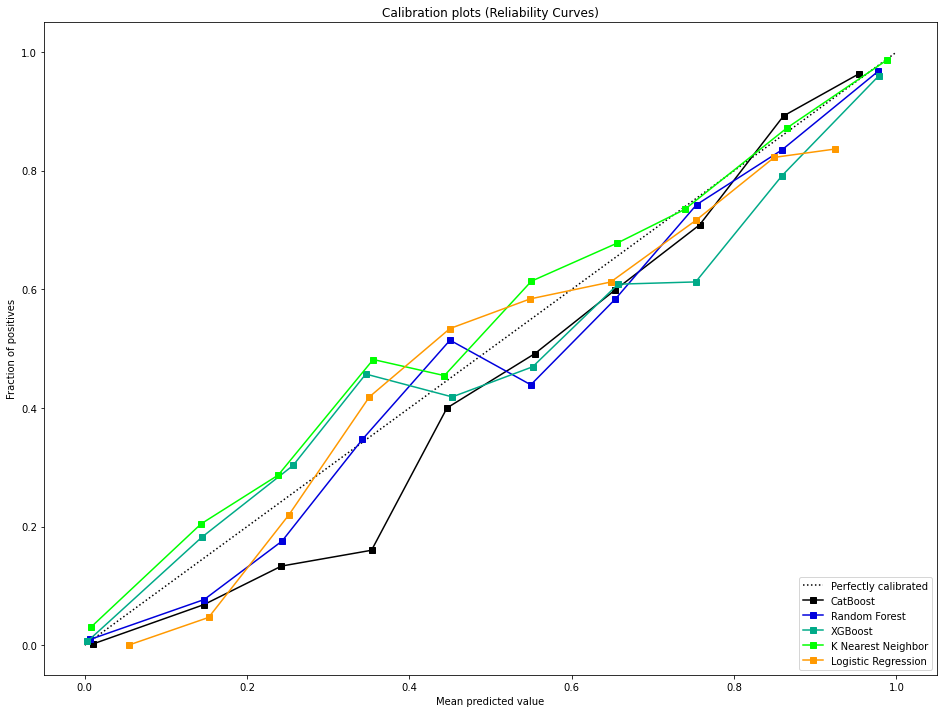

In [108]:
probas_list = [cat_probs, rf_probs, xgb_probs, knn_probs, log_probs]

clf_names = ['CatBoost', 'Random Forest', 'XGBoost', 'K Nearest Neighbor', 'Logistic Regression']

skplt.metrics.plot_calibration_curve(y_test, probas_list, clf_names, figsize=(16,12))
plt.show()